# Streamlined SR Benchmarking Analysis

This notebook performs the same analysis as `analysis-sept2.ipynb` but using modular plotting functions from `plotting_utils.py`.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import polars as pl
import os
import sys
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import time

# Add the src directory to the path
sys.path.append('/cephfs/home/lc865/workspace/similar-expressions/src')

# Import our plotting utilities
from SR_benchmarking.analysis.plotting_utils import (
    plot_basic_distributions,
    plot_comprehensive_comparison,
    plot_step_wise_metrics,
    categorize_difficulty,
    plot_difficulty_analysis,
    create_complexity_groups,
    plot_complexity_analysis,
    print_summary_statistics
)

## 1. Load and Process Data

In [2]:
# Define both experiment paths
experiment_paths = {
    'neural': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-4-neural',
    'vanilla': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-4-vanilla'
}

# Check if parquet files exist and load them, otherwise load from CSV files
all_data = []
for setup_name, experiment_path in experiment_paths.items():
    processed_dir = os.path.join(experiment_path, 'processed')
    parquet_filename = f'combined_tensorboard_data_{setup_name}.parquet'
    parquet_path = os.path.join(processed_dir, parquet_filename)
    
    if os.path.exists(parquet_path):
        # Load from existing parquet file using polars for speed
        print(f"Loading {setup_name} data from parquet file: {parquet_path}")
        df = pl.read_parquet(parquet_path).to_pandas()  # Convert to pandas for compatibility
        all_data.append(df)
    else:
        # Load from individual CSV files using polars for faster I/O
        print(f"Parquet file not found, loading {setup_name} data from CSV files")
        run_names = [run_name for run_name in os.listdir(experiment_path) 
                    if run_name.startswith('pysr-univariate_eq') and '_run' in run_name]
        
        csv_data = []
        for run_name in tqdm(run_names, desc=f"Loading {setup_name} tensorboard data"):
            csv_path = os.path.join(experiment_path, run_name, 'tensorboard_scalars.csv')
            if os.path.exists(csv_path):
                # Use polars for faster CSV reading
                df = pl.read_csv(csv_path).with_columns([
                    pl.lit(run_name).alias('run_name'),
                    pl.lit(setup_name).alias('setup')
                ])
                csv_data.append(df)
        
        if csv_data:
            # Combine all CSV data efficiently with polars
            combined_setup_df = pl.concat(csv_data).to_pandas()
            all_data.append(combined_setup_df)

# Combine all dataframes into one large table
combined_df = pd.concat(all_data, ignore_index=True)

# Only process the data if we loaded from CSV files
if not all(os.path.exists(os.path.join(experiment_paths[setup], 'processed', f'combined_tensorboard_data_{setup}.parquet')) 
           for setup in experiment_paths.keys()):
    # Extract dataset, equation, and run number from run_name
    combined_df[['dataset', 'eq', 'run']] = combined_df['run_name'].str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)')
    combined_df['eq'] = combined_df['eq'].astype(int)
    combined_df['run'] = combined_df['run'].astype(int)

    LOSS_LOWER_BOUND = 1e-8
    combined_df['min_loss'] = combined_df['min_loss'].clip(lower=LOSS_LOWER_BOUND)
    loss_columns = [col for col in combined_df.columns if col.startswith('loss_') and col[5:].isdigit()]
    for col in loss_columns:
        combined_df[col] = combined_df[col].clip(lower=LOSS_LOWER_BOUND)

print(f"Loaded data from {len(all_data)} runs with {len(combined_df)} total rows")
print(f"Setup distribution: {combined_df['setup'].value_counts().to_dict()}")

Loading neural data from parquet file: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-4-neural/processed/combined_tensorboard_data_neural.parquet
Loading vanilla data from parquet file: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-4-vanilla/processed/combined_tensorboard_data_vanilla.parquet
Loaded data from 2 runs with 9291724 total rows
Setup distribution: {'vanilla': 7677173, 'neural': 1614551}


## 2. Extract Results at Evaluation Steps

In [3]:
# Define the steps at which to extract results
EVALUATION_STEPS = [100, 300, 600, 929]  # 929 is the final step

print("Processing all evaluation steps...")
start_time = time.time()

# Create all step results in one comprehensive aggregation
result_data = []

# Get results for each (run_name, setup) combination
for (run_name, setup), group_df in combined_df.groupby(['run_name', 'setup']):
    row_data = {'run_name': run_name, 'setup': setup}
    
    # For each evaluation step, get cumulative best up to that step
    for eval_step in EVALUATION_STEPS:
        filtered_data = group_df[group_df['step'] <= eval_step]
        if len(filtered_data) > 0:
            row_data[f'actual_step_{eval_step}'] = filtered_data['step'].max()
            row_data[f'min_loss_step_{eval_step}'] = filtered_data['min_loss'].min()
            row_data[f'max_pareto_volume_step_{eval_step}'] = filtered_data['pareto_volume'].max()
        else:
            # If no data available, use first available data point
            first_row = group_df.iloc[0]
            row_data[f'actual_step_{eval_step}'] = first_row['step']
            row_data[f'min_loss_step_{eval_step}'] = first_row['min_loss']
            row_data[f'max_pareto_volume_step_{eval_step}'] = first_row['pareto_volume']
    
    # Add final step results (overall best)
    row_data['final_step'] = group_df['step'].max()
    row_data['final_min_loss'] = group_df['min_loss'].min()
    row_data['final_pareto_volume'] = group_df['pareto_volume'].max()
    
    result_data.append(row_data)

# Convert to DataFrame
final_results_df = pd.DataFrame(result_data)

end_time = time.time()
print(f"Processing completed in {end_time - start_time:.2f} seconds")
print(f"Final results table with {len(final_results_df)} runs and results at steps {EVALUATION_STEPS}")
final_results_df.head()

Processing all evaluation steps...
Processing completed in 20.40 seconds
Final results table with 12151 runs and results at steps [100, 300, 600, 929]


,run_name,setup,actual_step_100,min_loss_step_100,max_pareto_volume_step_100,actual_step_300,min_loss_step_300,max_pareto_volume_step_300,actual_step_600,min_loss_step_600,max_pareto_volume_step_600,actual_step_929,min_loss_step_929,max_pareto_volume_step_929,final_step,final_min_loss,final_pareto_volume
0,pysr-univariate_eq0_run0,neural,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000
1,pysr-univariate_eq0_run0,vanilla,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000
2,pysr-univariate_eq0_run1,neural,1,1.000000e-08,0.000051,1,1.000000e-08,0.000051,1,1.000000e-08,0.000051,1,1.000000e-08,0.000051,1,1.000000e-08,0.000051
3,pysr-univariate_eq0_run1,vanilla,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000
4,pysr-univariate_eq0_run2,neural,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000


In [4]:
# Extract dataset, equation, and run number from run_name using polars for speed
pl_results = pl.from_pandas(final_results_df)

# Extract metadata more efficiently
pl_results = pl_results.with_columns([
    pl.col('run_name').str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)', 1).alias('dataset'),
    pl.col('run_name').str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)', 2).cast(pl.Int64).alias('eq'),
    pl.col('run_name').str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)', 3).cast(pl.Int64).alias('run')
])

# Convert back to pandas for compatibility with plotting functions
final_results_df = pl_results.to_pandas()

# Count runs per equation and setup using polars
run_counts = (
    pl_results
    .group_by(['dataset', 'eq', 'setup'])
    .len()
    .rename({'len': 'n_runs'})
    .to_pandas()
)

# Find equations that have at least 10 runs for BOTH setups
equations_with_enough_runs_both = (
    run_counts[run_counts['n_runs'] >= 10]
    .groupby(['dataset', 'eq'])
    .size()
    .reset_index(name='setup_count')
)
equations_with_enough_runs_both = equations_with_enough_runs_both[
    equations_with_enough_runs_both['setup_count'] >= 2
][['dataset', 'eq']]

# Filter to only include these equations
filtered_df = final_results_df.merge(equations_with_enough_runs_both, on=['dataset', 'eq'], how='inner')

# Calculate summary statistics using polars for speed
pl_filtered = pl.from_pandas(filtered_df)
summary_stats = (
    pl_filtered
    .group_by(['dataset', 'eq', 'setup'])
    .agg([
        pl.col('final_min_loss').mean().alias('final_min_loss_mean'),
        pl.col('final_min_loss').std().alias('final_min_loss_std'),
        pl.col('final_pareto_volume').mean().alias('final_pareto_volume_mean'),
        pl.col('final_pareto_volume').std().alias('final_pareto_volume_std')
    ])
    .to_pandas()
)

print(f"Filtered to {filtered_df['eq'].nunique()} equations with sufficient runs for both setups")
print(f"Total filtered runs: {len(filtered_df)}")
summary_stats.head(10)

Filtered to 213 equations with sufficient runs for both setups
Total filtered runs: 4260


,dataset,eq,setup,final_min_loss_mean,final_min_loss_std,final_pareto_volume_mean,final_pareto_volume_std
0,univariate,24,vanilla,1.583603e-03,6.768750e-05,9.119382,0.010718
1,univariate,103,neural,5.210468e-07,1.669678e-08,7.295758,0.036430
2,univariate,156,neural,1.850124e-05,1.183575e-06,7.680606,0.031971
3,univariate,149,vanilla,5.012337e-08,8.039713e-08,5.347711,0.447109
4,univariate,21,neural,2.674671e-07,1.135163e-08,8.232008,0.022478
5,univariate,179,neural,1.002274e-08,4.559641e-11,3.982767,1.574237
6,univariate,134,vanilla,3.881337e-04,4.796048e-04,3.613357,1.560902
7,univariate,12,neural,1.466952e-07,4.322681e-07,7.897192,1.332303
8,univariate,31,vanilla,1.000000e-08,0.000000e+00,9.834039,8.952949
9,univariate,96,neural,2.956844e-07,1.943124e-07,6.676362,0.330825


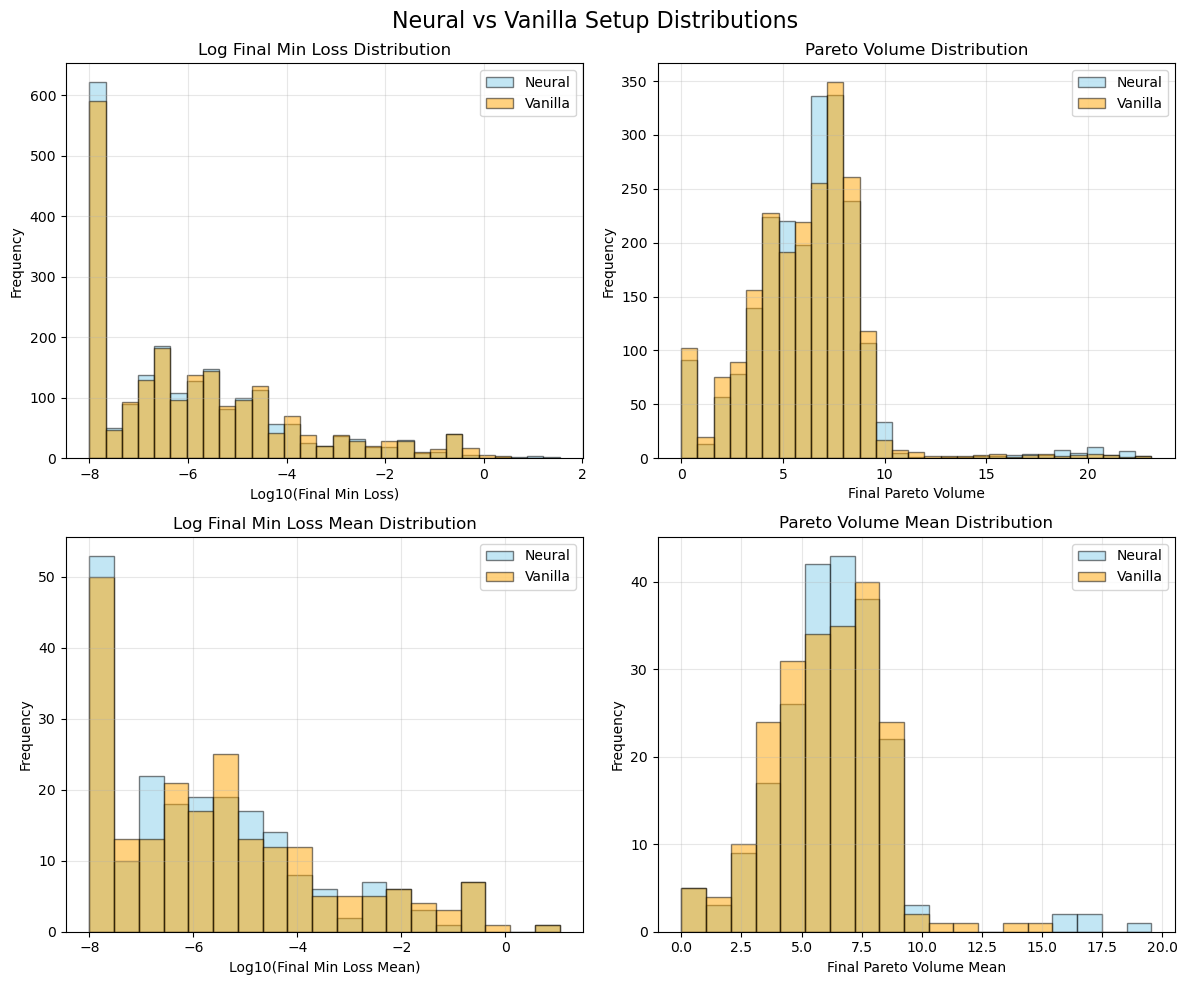

In [18]:
# Create basic distribution histograms
fig = plot_basic_distributions(filtered_df, summary_stats)
plt.show()

## 5. Comprehensive Comparison Plots

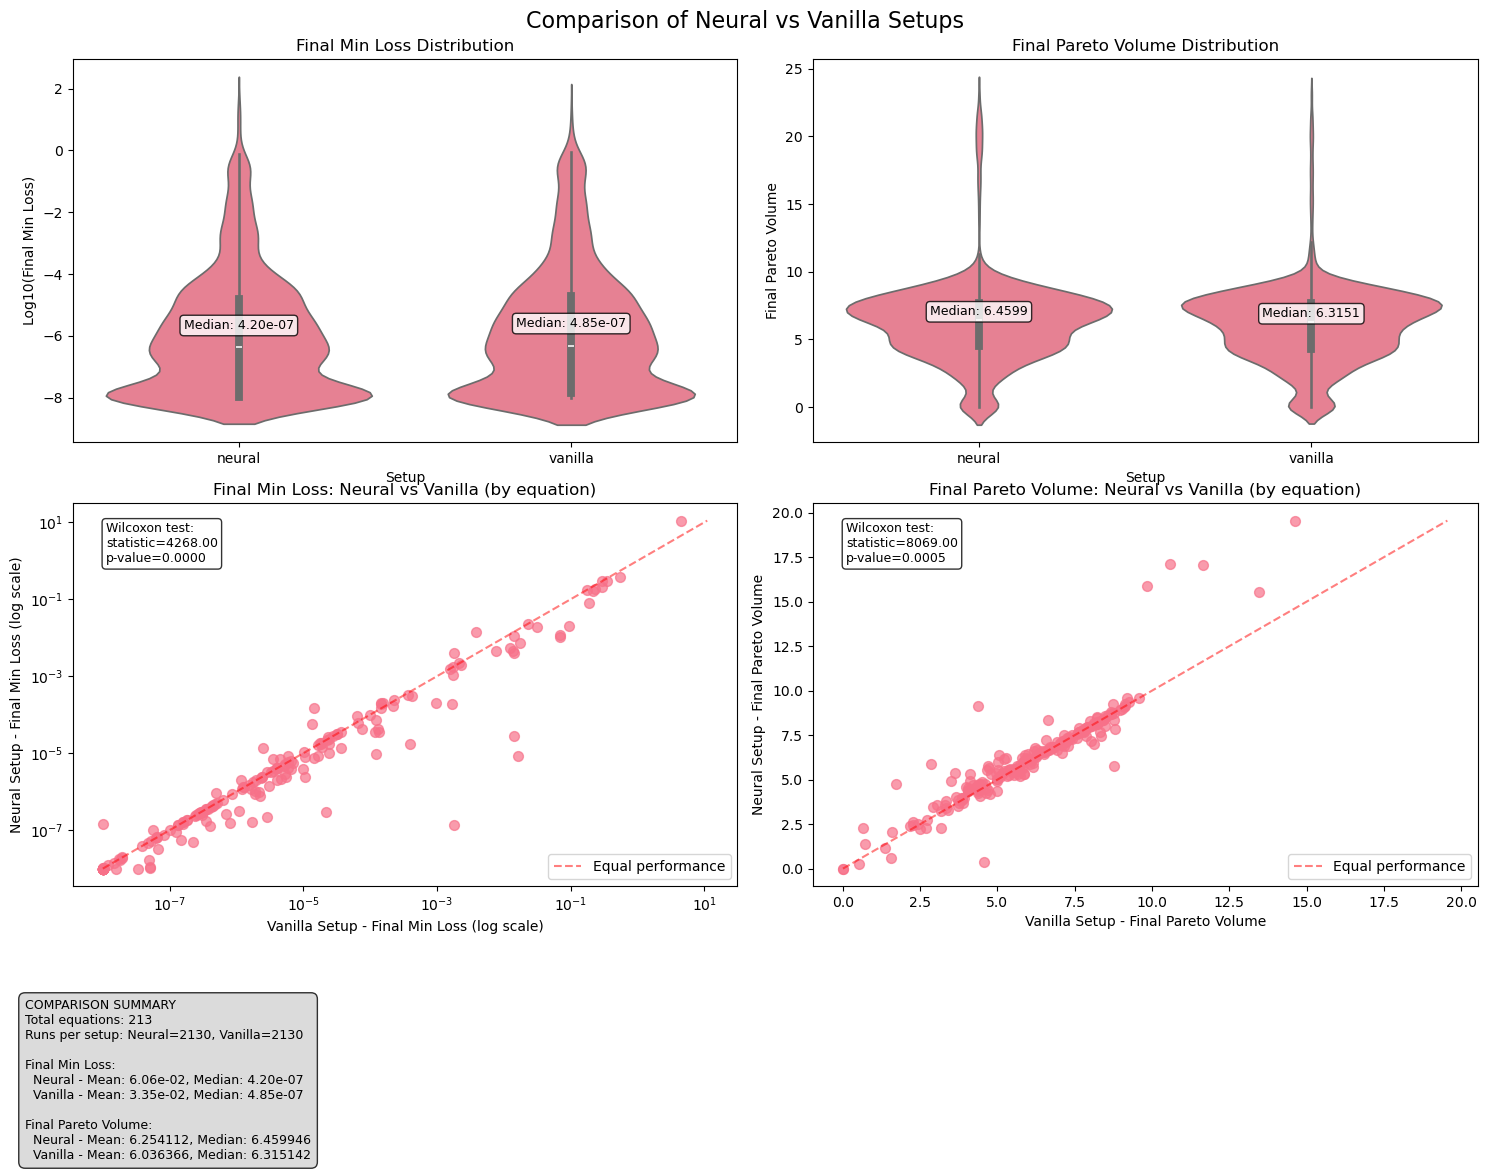

In [19]:
# Create comprehensive comparison plots with violin plots and scatter plots
fig = plot_comprehensive_comparison(filtered_df, summary_stats)
plt.show()

## 6. Step-wise Metric Analysis

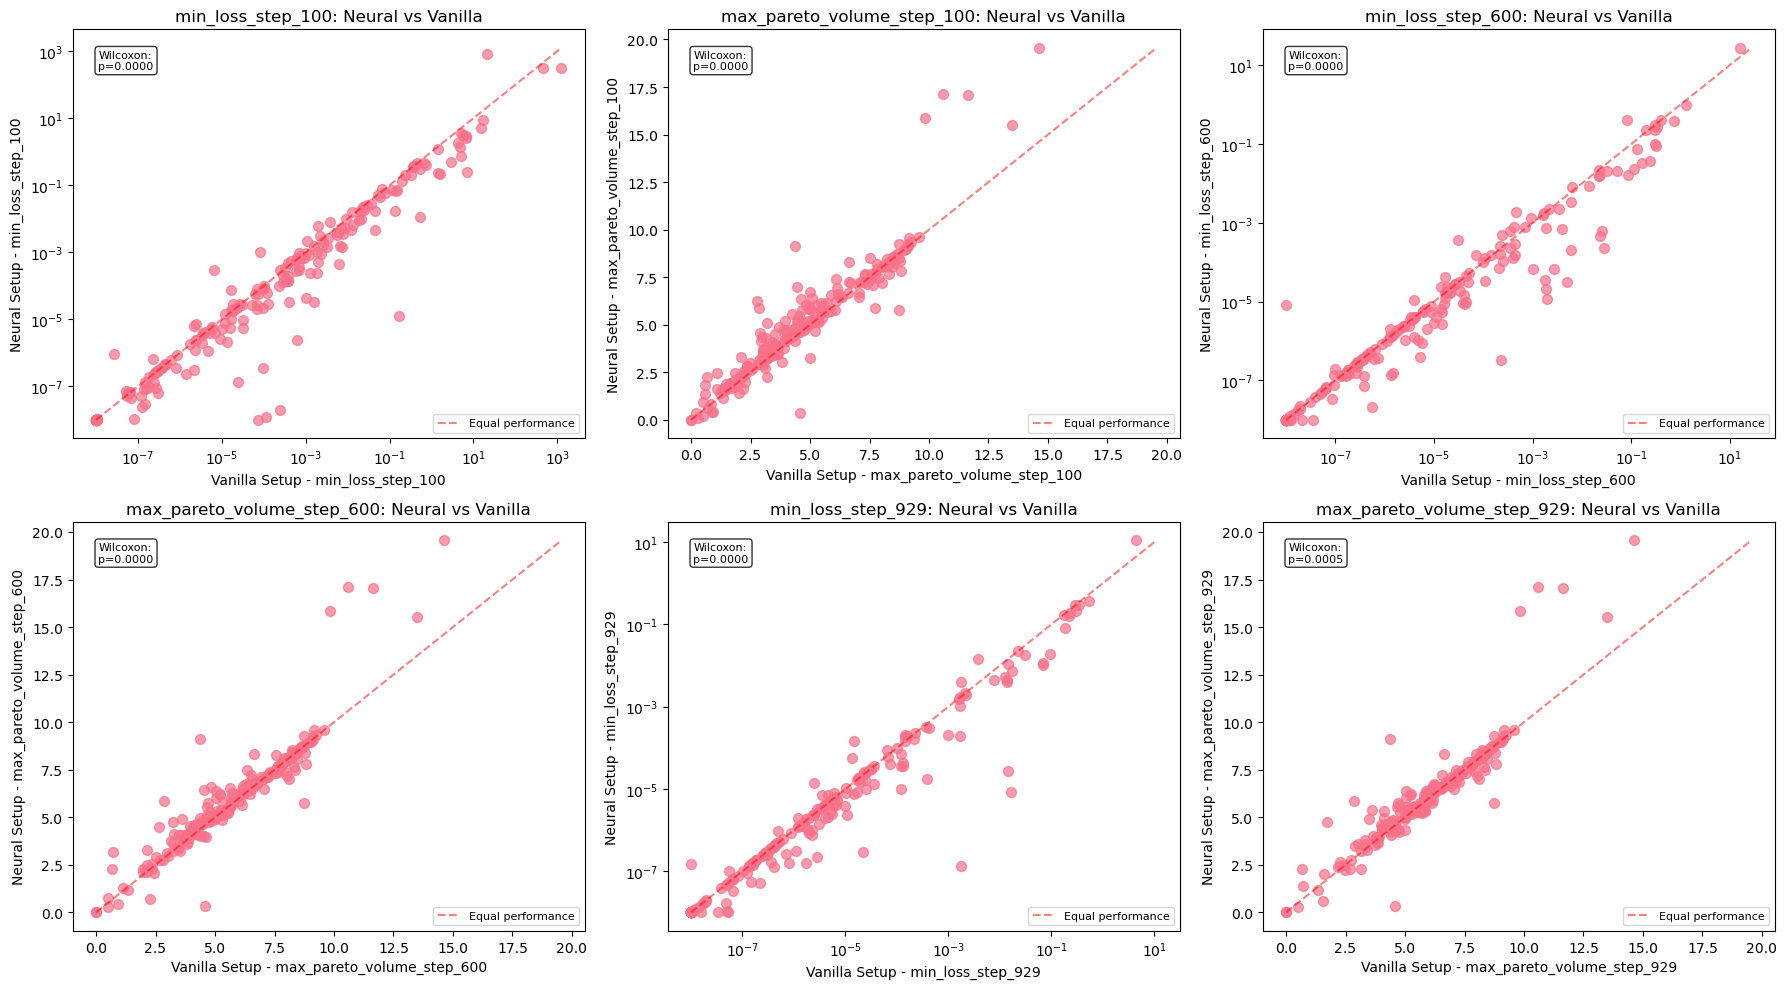

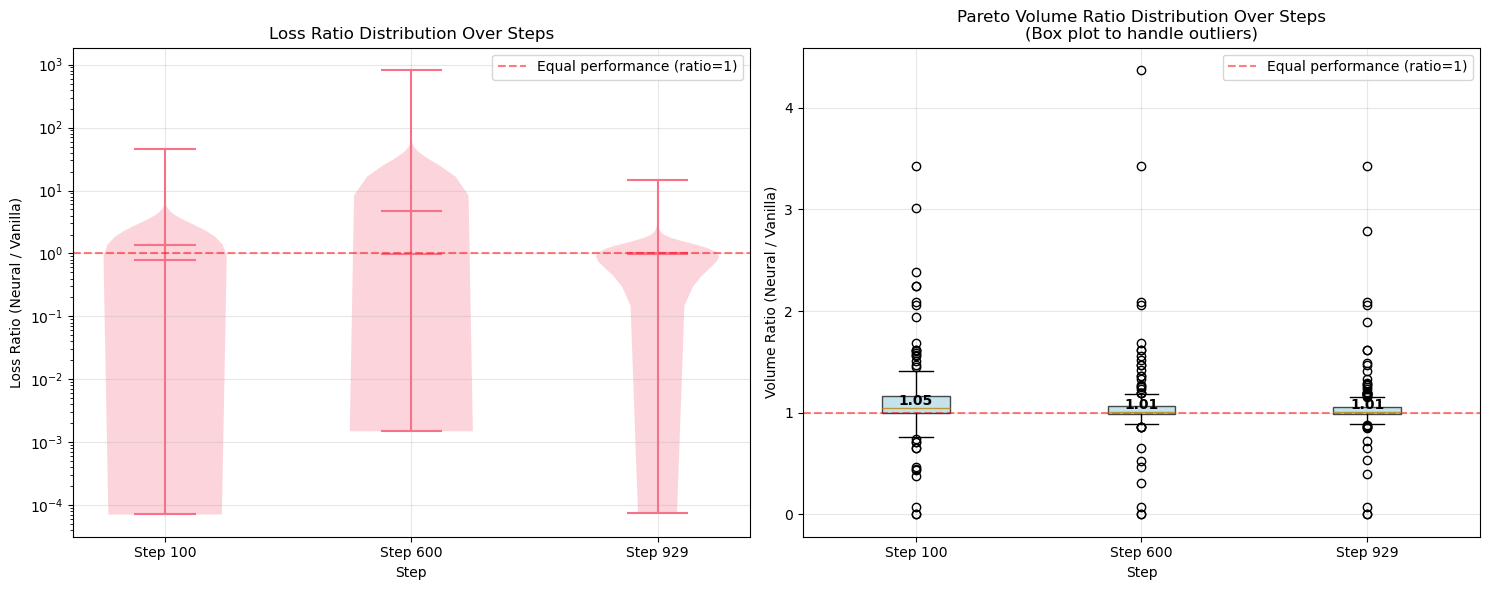

=== COMPREHENSIVE METRIC COMPARISON ===
                    Metric  Neural_Mean  Vanilla_Mean  Neural_Median  Vanilla_Median Wilcoxon_p
         min_loss_step_100     7.185829      8.517685   1.786850e-05    3.006517e-05   p=0.0000
max_pareto_volume_step_100     5.088746      4.716251   4.517409e+00    4.040162e+00   p=0.0000
         min_loss_step_600     0.145287      0.099638   6.237979e-07    1.250711e-06   p=0.0000
max_pareto_volume_step_600     6.062904      5.806458   6.322239e+00    6.020183e+00   p=0.0000
         min_loss_step_929     0.060648      0.033545   4.199659e-07    4.850538e-07   p=0.0000
max_pareto_volume_step_929     6.254112      6.036366   6.459946e+00    6.315142e+00   p=0.0000


In [20]:
# Create step-wise metric comparison plots
fig1, fig2 = plot_step_wise_metrics(filtered_df)
plt.show()

# Print comprehensive summary statistics
print_summary_statistics(filtered_df)

## 7. Difficulty-based Analysis

=== DIFFICULTY CATEGORIZATION ===
Easy threshold (min loss): 1.60e-07
Medium threshold (min loss): 1.08e-05

Equations per difficulty:
difficulty
Difficult    70
Easy         70
Medium       73
Name: eq, dtype: int64


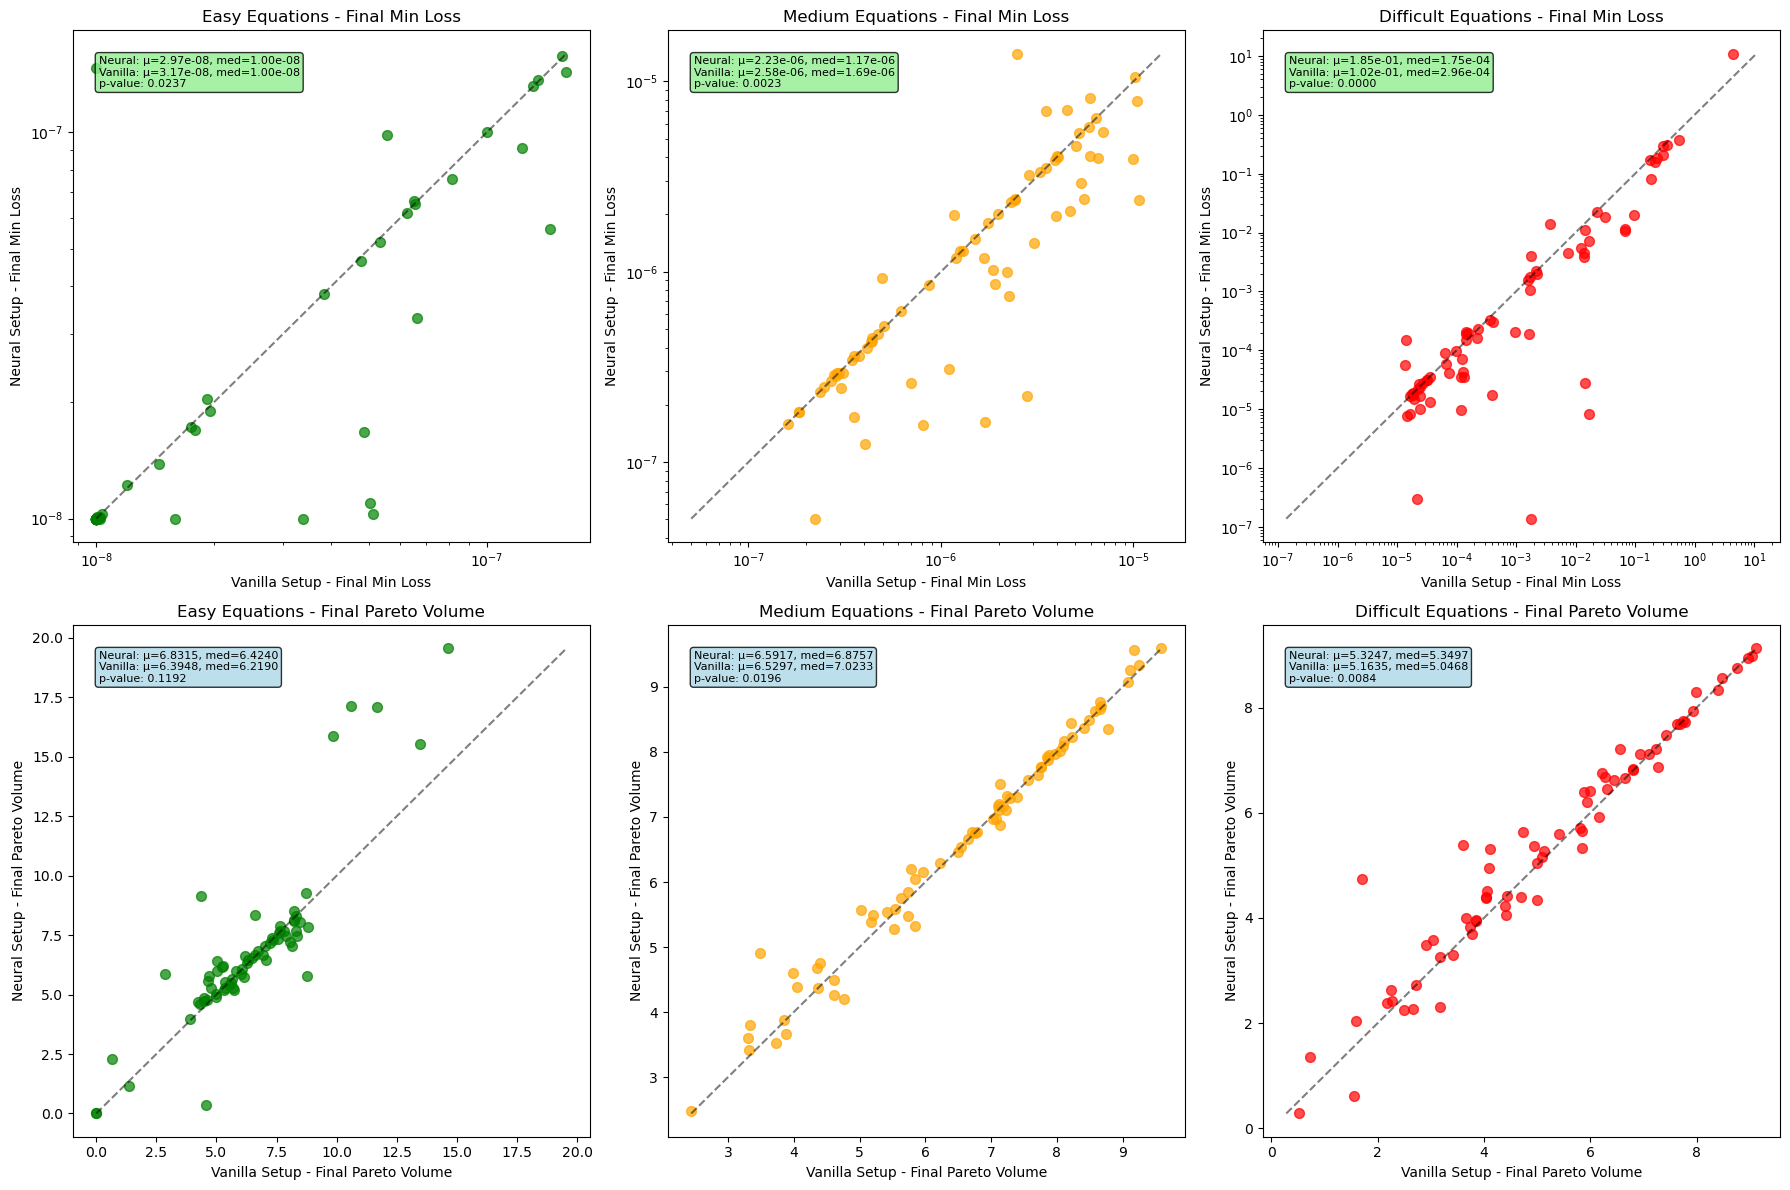


=== DETAILED STATISTICS BY DIFFICULTY ===

EASY EQUATIONS:
  Number of equations: 70
  Final Min Loss:
    Neural - Mean: 2.97e-08, Median: 1.00e-08
    Vanilla - Mean: 3.17e-08, Median: 1.00e-08
  Final Pareto Volume:
    Neural - Mean: 6.831455, Median: 6.508462
    Vanilla - Mean: 6.394788, Median: 6.399395

MEDIUM EQUATIONS:
  Number of equations: 73
  Final Min Loss:
    Neural - Mean: 2.23e-06, Median: 6.04e-07
    Vanilla - Mean: 2.58e-06, Median: 9.33e-07
  Final Pareto Volume:
    Neural - Mean: 6.591735, Median: 6.934415
    Vanilla - Mean: 6.529717, Median: 7.067019

DIFFICULT EQUATIONS:
  Number of equations: 70
  Final Min Loss:
    Neural - Mean: 1.85e-01, Median: 5.08e-05
    Vanilla - Mean: 1.02e-01, Median: 1.02e-04
  Final Pareto Volume:
    Neural - Mean: 5.324677, Median: 5.399558
    Vanilla - Mean: 5.163451, Median: 5.206466


In [21]:
# Categorize equations by difficulty
filtered_df = categorize_difficulty(filtered_df)

# Print difficulty distribution
print("=== DIFFICULTY CATEGORIZATION ===")
vanilla_eq_performance = filtered_df[filtered_df['setup'] == 'vanilla'].groupby('eq')['final_min_loss'].mean()
easy_threshold = vanilla_eq_performance.quantile(0.33)
medium_threshold = vanilla_eq_performance.quantile(0.67)
print(f"Easy threshold (min loss): {easy_threshold:.2e}")
print(f"Medium threshold (min loss): {medium_threshold:.2e}")
print("\nEquations per difficulty:")
print(filtered_df.groupby('difficulty')['eq'].nunique())

# Create difficulty analysis plots
fig = plot_difficulty_analysis(filtered_df)
plt.show()

# Print detailed statistics by difficulty
print("\n=== DETAILED STATISTICS BY DIFFICULTY ===")
for difficulty in ['Easy', 'Medium', 'Difficult']:
    print(f"\n{difficulty.upper()} EQUATIONS:")
    diff_data = filtered_df[filtered_df['difficulty'] == difficulty]
    
    neural_data = diff_data[diff_data['setup'] == 'neural']
    vanilla_data = diff_data[diff_data['setup'] == 'vanilla']
    
    print(f"  Number of equations: {diff_data['eq'].nunique()}")
    print(f"  Final Min Loss:")
    print(f"    Neural - Mean: {neural_data['final_min_loss'].mean():.2e}, Median: {neural_data['final_min_loss'].median():.2e}")
    print(f"    Vanilla - Mean: {vanilla_data['final_min_loss'].mean():.2e}, Median: {vanilla_data['final_min_loss'].median():.2e}")
    
    print(f"  Final Pareto Volume:")
    print(f"    Neural - Mean: {neural_data['final_pareto_volume'].mean():.6f}, Median: {neural_data['final_pareto_volume'].median():.6f}")
    print(f"    Vanilla - Mean: {vanilla_data['final_pareto_volume'].mean():.6f}, Median: {vanilla_data['final_pareto_volume'].median():.6f}")

## 8. Complexity and Evaluation Std Analysis

=== DATA DISTRIBUTION ANALYSIS ===
Total equations in metadata: 2018
Complexity simplified range: 0.000 to 27.000
Eval std range: 0.000000 to 761995016498060288.000000

Complexity simplified distribution:
count    2018.000000
mean        9.626363
std         5.448742
min         0.000000
25%         5.000000
50%         9.000000
75%        13.000000
max        27.000000
Name: complexity_simplified, dtype: float64

Eval std distribution:
count    2.000000e+03
mean     7.817692e+14
std      2.152915e+16
min      0.000000e+00
25%      4.343866e-01
50%      2.316958e+00
75%      1.664579e+01
max      7.619950e+17
Name: eval_std, dtype: float64

Unique complexity values: 28
Unique eval_std values: 1867

Complexity groups distribution:
complexity_group
Medium    760
Low       678
High      580
Name: count, dtype: int64

Eval std groups distribution:
eval_std_group
Low       667
High      667
Medium    666
Name: count, dtype: int64

Equations in filtered_df: [np.int64(0), np.int64(1), np.int6

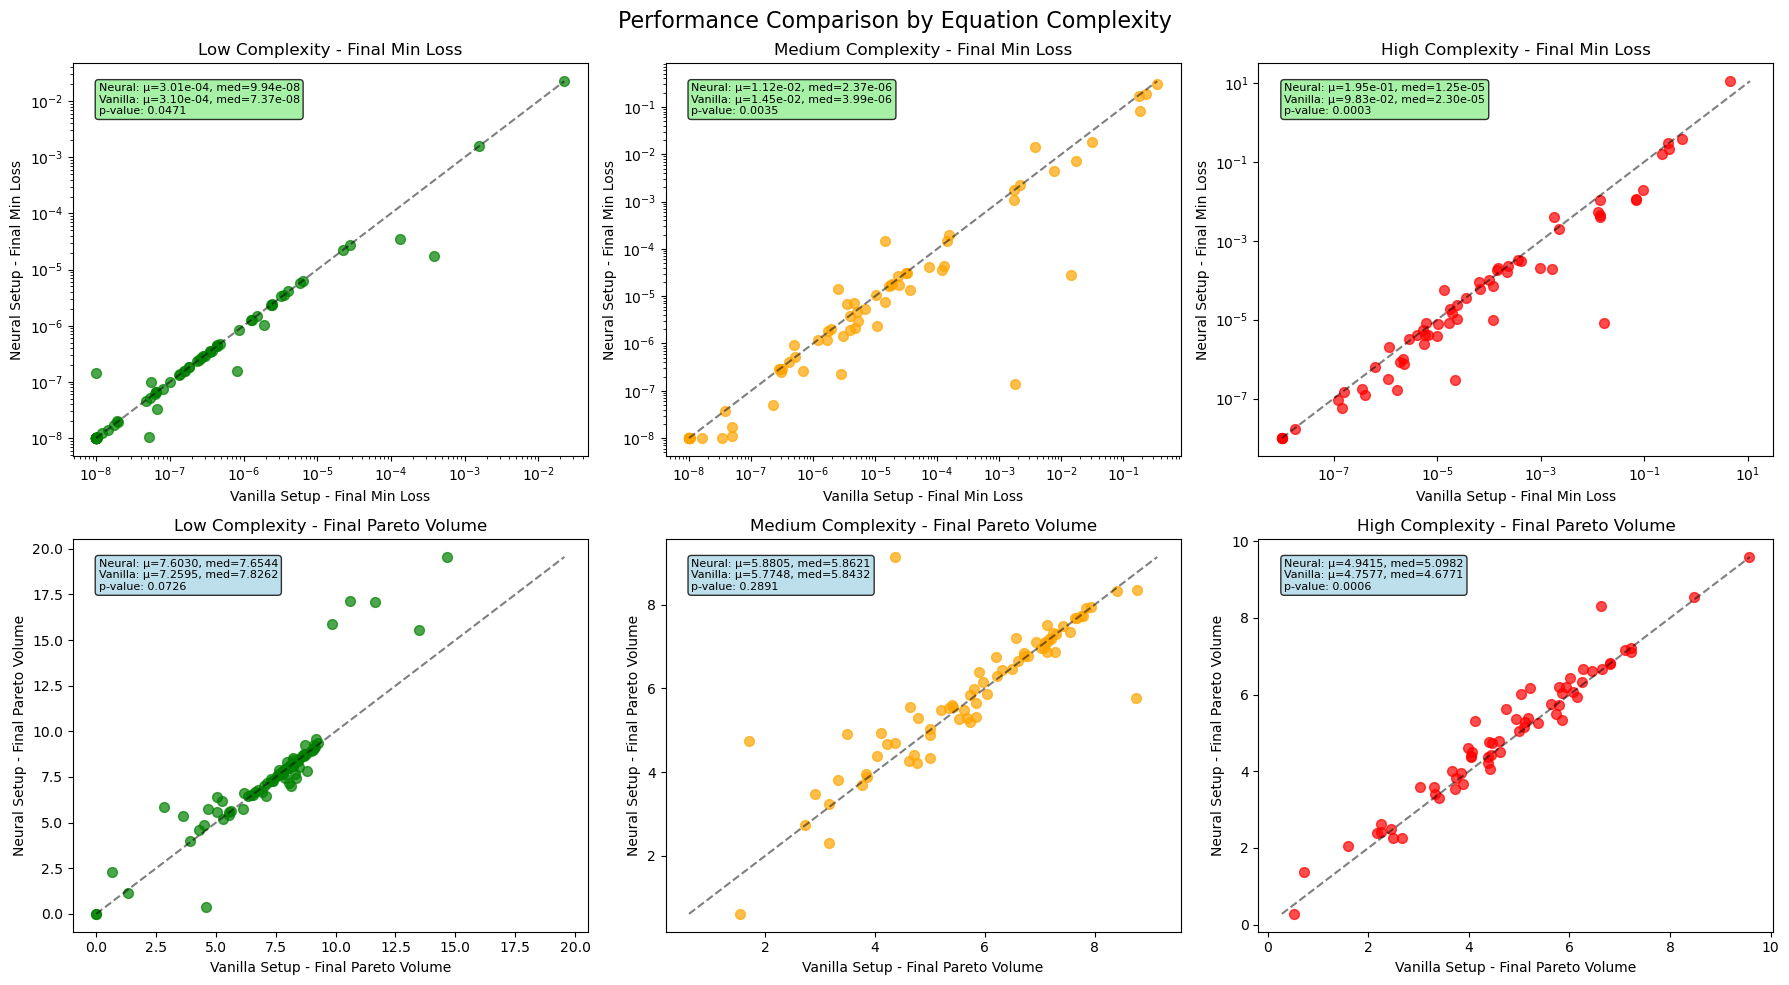

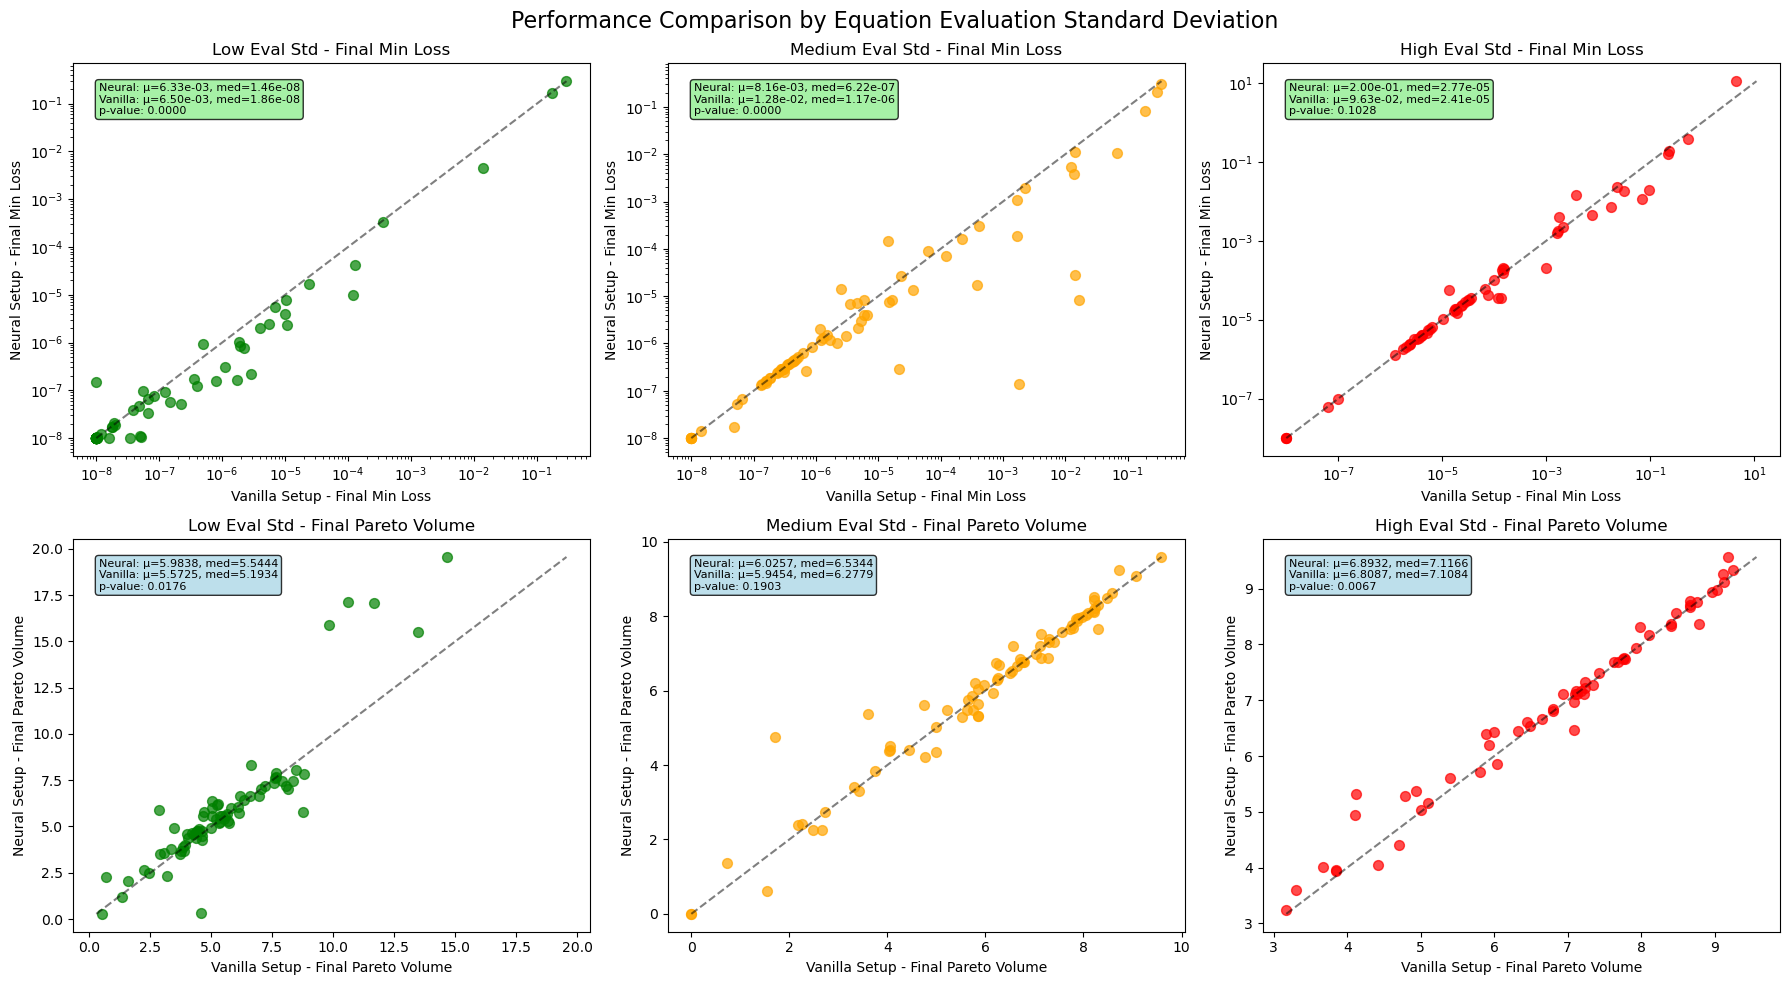


Merge results:
Rows before merge: 4260
Rows after merge: 4260
Missing complexity groups: 0
Missing eval_std groups: 60

=== DETAILED STATISTICS BY COMPLEXITY ===

LOW COMPLEXITY:
  Number of equations: 80
  Final Min Loss:
    Neural - Mean: 3.01e-04, Median: 6.68e-08
    Vanilla - Mean: 3.10e-04, Median: 6.64e-08
  Final Pareto Volume:
    Neural - Mean: 7.603037, Median: 7.759538
    Vanilla - Mean: 7.259454, Median: 7.778099

MEDIUM COMPLEXITY:
  Number of equations: 71
  Final Min Loss:
    Neural - Mean: 1.12e-02, Median: 9.61e-07
    Vanilla - Mean: 1.45e-02, Median: 1.09e-06
  Final Pareto Volume:
    Neural - Mean: 5.880454, Median: 6.230847
    Vanilla - Mean: 5.774809, Median: 6.202078

HIGH COMPLEXITY:
  Number of equations: 62
  Final Min Loss:
    Neural - Mean: 1.95e-01, Median: 8.50e-06
    Vanilla - Mean: 9.83e-02, Median: 1.40e-05
  Final Pareto Volume:
    Neural - Mean: 4.941463, Median: 4.899171
    Vanilla - Mean: 4.757714, Median: 4.710175

=== DETAILED STATISTIC

In [22]:
# Load equation metadata
eq_df = pd.read_csv('/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking/dataset/PySR-univariate.csv')

# Debug the data distribution first
print("=== DATA DISTRIBUTION ANALYSIS ===")
print(f"Total equations in metadata: {len(eq_df)}")
print(f"Complexity simplified range: {eq_df['complexity_simplified'].min():.3f} to {eq_df['complexity_simplified'].max():.3f}")
print(f"Eval std range: {eq_df['eval_std'].min():.6f} to {eq_df['eval_std'].max():.6f}")

print(f"\nComplexity simplified distribution:")
print(eq_df['complexity_simplified'].describe())

print(f"\nEval std distribution:")
print(eq_df['eval_std'].describe())

# Check for unique values
print(f"\nUnique complexity values: {len(eq_df['complexity_simplified'].unique())}")
print(f"Unique eval_std values: {len(eq_df['eval_std'].unique())}")

# Create complexity and evaluation std groups using log transformation and quantiles
eq_df = create_complexity_groups(eq_df)

# Check the group distributions
print(f"\nComplexity groups distribution:")
print(eq_df['complexity_group'].value_counts())

print(f"\nEval std groups distribution:")
print(eq_df['eval_std_group'].value_counts())

# Check which equations we actually have data for
print(f"\nEquations in filtered_df: {sorted(filtered_df['eq'].unique())[:10]}... (showing first 10)")
print(f"Equations in eq_df: {sorted(eq_df.index.tolist())[:10]}... (showing first 10)")

# Create complexity and eval std analysis plots
fig1, fig2 = plot_complexity_analysis(filtered_df, eq_df)
plt.show()

# Print detailed statistics by complexity and eval std
# Create proper mapping from equation ID to groups
if 'eq' in eq_df.columns:
    eq_groups = eq_df[['eq', 'complexity_group', 'eval_std_group']].copy()
else:
    eq_groups = eq_df[['complexity_group', 'eval_std_group']].copy()
    eq_groups['eq'] = eq_groups.index

# Merge with equation groups for statistics
filtered_df_with_groups = filtered_df.merge(eq_groups, on='eq', how='left')

# Check the merge results
print(f"\nMerge results:")
print(f"Rows before merge: {len(filtered_df)}")
print(f"Rows after merge: {len(filtered_df_with_groups)}")
print(f"Missing complexity groups: {filtered_df_with_groups['complexity_group'].isna().sum()}")
print(f"Missing eval_std groups: {filtered_df_with_groups['eval_std_group'].isna().sum()}")

print("\n=== DETAILED STATISTICS BY COMPLEXITY ===")
for complexity in ['Low', 'Medium', 'High']:
    print(f"\n{complexity.upper()} COMPLEXITY:")
    comp_data = filtered_df_with_groups[filtered_df_with_groups['complexity_group'] == complexity]
    
    if len(comp_data) > 0:
        neural_data = comp_data[comp_data['setup'] == 'neural']
        vanilla_data = comp_data[comp_data['setup'] == 'vanilla']
        
        print(f"  Number of equations: {comp_data['eq'].nunique()}")
        print(f"  Final Min Loss:")
        if len(neural_data) > 0 and len(vanilla_data) > 0:
            print(f"    Neural - Mean: {neural_data['final_min_loss'].mean():.2e}, Median: {neural_data['final_min_loss'].median():.2e}")
            print(f"    Vanilla - Mean: {vanilla_data['final_min_loss'].mean():.2e}, Median: {vanilla_data['final_min_loss'].median():.2e}")
            
            print(f"  Final Pareto Volume:")
            print(f"    Neural - Mean: {neural_data['final_pareto_volume'].mean():.6f}, Median: {neural_data['final_pareto_volume'].median():.6f}")
            print(f"    Vanilla - Mean: {vanilla_data['final_pareto_volume'].mean():.6f}, Median: {vanilla_data['final_pareto_volume'].median():.6f}")
        else:
            print("    No data available for this complexity group")
    else:
        print("  No equations found for this complexity group")

print("\n=== DETAILED STATISTICS BY EVALUATION STANDARD DEVIATION ===")
for eval_std in ['Low', 'Medium', 'High']:
    print(f"\n{eval_std.upper()} EVAL STD:")
    std_data = filtered_df_with_groups[filtered_df_with_groups['eval_std_group'] == eval_std]
    
    if len(std_data) > 0:
        neural_data = std_data[std_data['setup'] == 'neural']
        vanilla_data = std_data[std_data['setup'] == 'vanilla']
        
        print(f"  Number of equations: {std_data['eq'].nunique()}")
        print(f"  Final Min Loss:")
        if len(neural_data) > 0 and len(vanilla_data) > 0:
            print(f"    Neural - Mean: {neural_data['final_min_loss'].mean():.2e}, Median: {neural_data['final_min_loss'].median():.2e}")
            print(f"    Vanilla - Mean: {vanilla_data['final_min_loss'].mean():.2e}, Median: {vanilla_data['final_min_loss'].median():.2e}")
            
            print(f"  Final Pareto Volume:")
            print(f"    Neural - Mean: {neural_data['final_pareto_volume'].mean():.6f}, Median: {neural_data['final_pareto_volume'].median():.6f}")
            print(f"    Vanilla - Mean: {vanilla_data['final_pareto_volume'].mean():.6f}, Median: {vanilla_data['final_pareto_volume'].median():.6f}")
        else:
            print("    No data available for this eval std group")
    else:
        print("  No equations found for this eval std group")

## Summary

This streamlined notebook provides the same comprehensive analysis as the original `analysis-sept2.ipynb` but with improved code organization through modular plotting functions. The analysis includes:

1. **Basic Distributions**: Histograms comparing neural vs vanilla setups
2. **Comprehensive Comparison**: Violin plots and scatter plots with statistical tests
3. **Step-wise Analysis**: Performance across different evaluation steps and ratio analysis
4. **Difficulty Analysis**: Categorization based on vanilla performance
5. **Complexity Analysis**: Grouping by equation complexity and evaluation standard deviation

All plotting functions are now reusable and can be imported for other analyses.

In [6]:
print(final_results_df.shape)
final_results_df.head()

(12151, 20)


,run_name,setup,actual_step_100,min_loss_step_100,max_pareto_volume_step_100,actual_step_300,min_loss_step_300,max_pareto_volume_step_300,actual_step_600,min_loss_step_600,max_pareto_volume_step_600,actual_step_929,min_loss_step_929,max_pareto_volume_step_929,final_step,final_min_loss,final_pareto_volume,dataset,eq,run
0,pysr-univariate_eq0_run0,neural,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,univariate,0,0
1,pysr-univariate_eq0_run0,vanilla,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,univariate,0,0
2,pysr-univariate_eq0_run1,neural,1,1.000000e-08,0.000051,1,1.000000e-08,0.000051,1,1.000000e-08,0.000051,1,1.000000e-08,0.000051,1,1.000000e-08,0.000051,univariate,0,1
3,pysr-univariate_eq0_run1,vanilla,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,univariate,0,1
4,pysr-univariate_eq0_run2,neural,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,1,1.000000e-08,0.000000,univariate,0,2


In [7]:
print(summary_stats.shape)
summary_stats.head()

(426, 7)


,dataset,eq,setup,final_min_loss_mean,final_min_loss_std,final_pareto_volume_mean,final_pareto_volume_std
0,univariate,24,vanilla,1.583603e-03,6.768750e-05,9.119382,0.010718
1,univariate,103,neural,5.210468e-07,1.669678e-08,7.295758,0.036430
2,univariate,156,neural,1.850124e-05,1.183575e-06,7.680606,0.031971
3,univariate,149,vanilla,5.012337e-08,8.039713e-08,5.347711,0.447109
4,univariate,21,neural,2.674671e-07,1.135163e-08,8.232008,0.022478


In [8]:
# Calculate variance metrics for Pareto volume and min loss
print("=== VARIANCE ANALYSIS ===")
print("\nAnalyzing variance across runs to determine required sample size for reliable means\n")

# Calculate variance metrics for each equation
equation_variance = final_results_df.groupby(['dataset', 'eq', 'setup']).agg({
    'final_min_loss': ['mean', 'std', 'var', 'count'],
    'final_pareto_volume': ['mean', 'std', 'var', 'count']
}).round(6)

# Flatten column names
equation_variance.columns = ['_'.join(col).strip() for col in equation_variance.columns]
equation_variance = equation_variance.reset_index()

print("1. EQUATION-LEVEL VARIANCE METRICS")
print("=" * 50)

# Calculate coefficient of variation (CV) for better comparison
equation_variance['min_loss_cv'] = equation_variance['final_min_loss_std'] / equation_variance['final_min_loss_mean']
equation_variance['pareto_vol_cv'] = equation_variance['final_pareto_volume_std'] / equation_variance['final_pareto_volume_mean']

# Replace inf values with NaN for cleaner display
equation_variance = equation_variance.replace([np.inf, -np.inf], np.nan)

print(f"Summary of Coefficient of Variation (CV = std/mean):")
print(f"Min Loss CV - Mean: {equation_variance['min_loss_cv'].mean():.3f}, Median: {equation_variance['min_loss_cv'].median():.3f}")
print(f"Pareto Volume CV - Mean: {equation_variance['pareto_vol_cv'].mean():.3f}, Median: {equation_variance['pareto_vol_cv'].median():.3f}")

print(f"\nEquations with highest variance in min loss:")
high_var_loss = equation_variance.nlargest(5, 'final_min_loss_var')[['dataset', 'eq', 'setup', 'final_min_loss_mean', 'final_min_loss_std', 'min_loss_cv']]
print(high_var_loss.to_string(index=False))

print(f"\nEquations with highest variance in Pareto volume:")
high_var_pareto = equation_variance.nlargest(5, 'final_pareto_volume_var')[['dataset', 'eq', 'setup', 'final_pareto_volume_mean', 'final_pareto_volume_std', 'pareto_vol_cv']]
print(high_var_pareto.to_string(index=False))

print("\n2. OVERALL VARIANCE METRICS")
print("=" * 50)

# Overall variance by setup
overall_variance = final_results_df.groupby('setup').agg({
    'final_min_loss': ['mean', 'std', 'var', 'count'],
    'final_pareto_volume': ['mean', 'std', 'var', 'count']
}).round(6)

overall_variance.columns = ['_'.join(col).strip() for col in overall_variance.columns]
print("Overall variance by setup:")
print(overall_variance)

# Calculate pooled variance for sample size estimation
print("\n3. SAMPLE SIZE ESTIMATION")
print("=" * 50)

def calculate_required_sample_size(std, mean, margin_of_error=0.05, confidence_level=0.95):
    """Calculate required sample size for a given margin of error"""
    from scipy import stats
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    # For relative margin of error (as fraction of mean)
    required_n = (z_score * std / (margin_of_error * mean)) ** 2
    return int(np.ceil(required_n))

print("Required sample sizes for 95% confidence with 5% margin of error (relative to mean):")
print("-" * 80)

for setup in ['neural', 'vanilla']:
    setup_data = final_results_df[final_results_df['setup'] == setup]
    
    # Calculate pooled standard deviation across all equations
    loss_std = setup_data['final_min_loss'].std()
    loss_mean = setup_data['final_min_loss'].mean()
    pareto_std = setup_data['final_pareto_volume'].std()
    pareto_mean = setup_data['final_pareto_volume'].mean()
    
    loss_n = calculate_required_sample_size(loss_std, loss_mean)
    pareto_n = calculate_required_sample_size(pareto_std, pareto_mean)
    
    print(f"{setup.upper()} setup:")
    print(f"  Min Loss: {loss_n} runs needed (current std: {loss_std:.2e}, mean: {loss_mean:.2e})")
    print(f"  Pareto Volume: {pareto_n} runs needed (current std: {pareto_std:.6f}, mean: {pareto_mean:.6f})")

# Calculate margin of error with current sample size (10 runs)
print(f"\nWith current sample size (10 runs), margin of error at 95% confidence:")
print("-" * 70)

from scipy import stats
z_score = stats.norm.ppf(0.975)  # 95% confidence
n_current = 10

for setup in ['neural', 'vanilla']:
    setup_data = final_results_df[final_results_df['setup'] == setup]
    
    loss_std = setup_data['final_min_loss'].std()
    loss_mean = setup_data['final_min_loss'].mean()
    pareto_std = setup_data['final_pareto_volume'].std()
    pareto_mean = setup_data['final_pareto_volume'].mean()
    
    loss_margin = (z_score * loss_std / np.sqrt(n_current)) / loss_mean * 100
    pareto_margin = (z_score * pareto_std / np.sqrt(n_current)) / pareto_mean * 100
    
    print(f"{setup.upper()} setup:")
    print(f"  Min Loss: ±{loss_margin:.1f}% of mean")
    print(f"  Pareto Volume: ±{pareto_margin:.1f}% of mean")

print("\n4. VARIANCE BY EQUATION DIFFICULTY")
print("=" * 50)

# Analyze variance by difficulty categories
if 'difficulty_category' in final_results_df.columns:
    difficulty_variance = final_results_df.groupby(['difficulty_category', 'setup']).agg({
        'final_min_loss': ['std', 'mean'],
        'final_pareto_volume': ['std', 'mean']
    }).round(6)
    
    difficulty_variance.columns = ['_'.join(col).strip() for col in difficulty_variance.columns]
    difficulty_variance['min_loss_cv'] = difficulty_variance['final_min_loss_std'] / difficulty_variance['final_min_loss_mean']
    difficulty_variance['pareto_vol_cv'] = difficulty_variance['final_pareto_volume_std'] / difficulty_variance['final_pareto_volume_mean']
    
    print("Coefficient of Variation by difficulty category:")
    print(difficulty_variance[['min_loss_cv', 'pareto_vol_cv']].to_string())
else:
    print("Difficulty categories not available in dataset")


=== VARIANCE ANALYSIS ===

Analyzing variance across runs to determine required sample size for reliable means

1. EQUATION-LEVEL VARIANCE METRICS
Summary of Coefficient of Variation (CV = std/mean):
Min Loss CV - Mean: 0.876, Median: 0.750
Pareto Volume CV - Mean: 0.193, Median: 0.089

Equations with highest variance in min loss:
   dataset  eq   setup  final_min_loss_mean  final_min_loss_std  min_loss_cv
univariate 457 vanilla           144.785724          253.179004     1.748646
univariate 358 vanilla           175.907336          213.915364     1.216068
univariate 891 vanilla            13.063083           15.709490     1.202587
univariate 202  neural            10.993515           10.643955     0.968203
univariate 942 vanilla             7.242920            9.142850     1.262315

Equations with highest variance in Pareto volume:
   dataset  eq   setup  final_pareto_volume_mean  final_pareto_volume_std  pareto_vol_cv
univariate 582 vanilla                 11.380040                 

## Runtime analysis


VANILLA SETUP:
------------------------------
Per-run runtime (minutes, 9499 runs):
  Mean: 0.28
  Median: 0.26
  Std: 0.17

Normalized by run count:
  Overhead per run - Mean: 0.18
  Overhead per run - Median: 0.06
  Total time per run - Mean: 0.45
  Total time per run - Median: 0.33

NEURAL SETUP:
------------------------------
Per-run runtime (minutes, 2027 runs):
  Mean: 1.58
  Median: 1.22
  Std: 1.82

Normalized by run count:
  Overhead per run - Mean: 0.41
  Overhead per run - Median: 0.10
  Total time per run - Mean: 1.98
  Total time per run - Median: 1.32


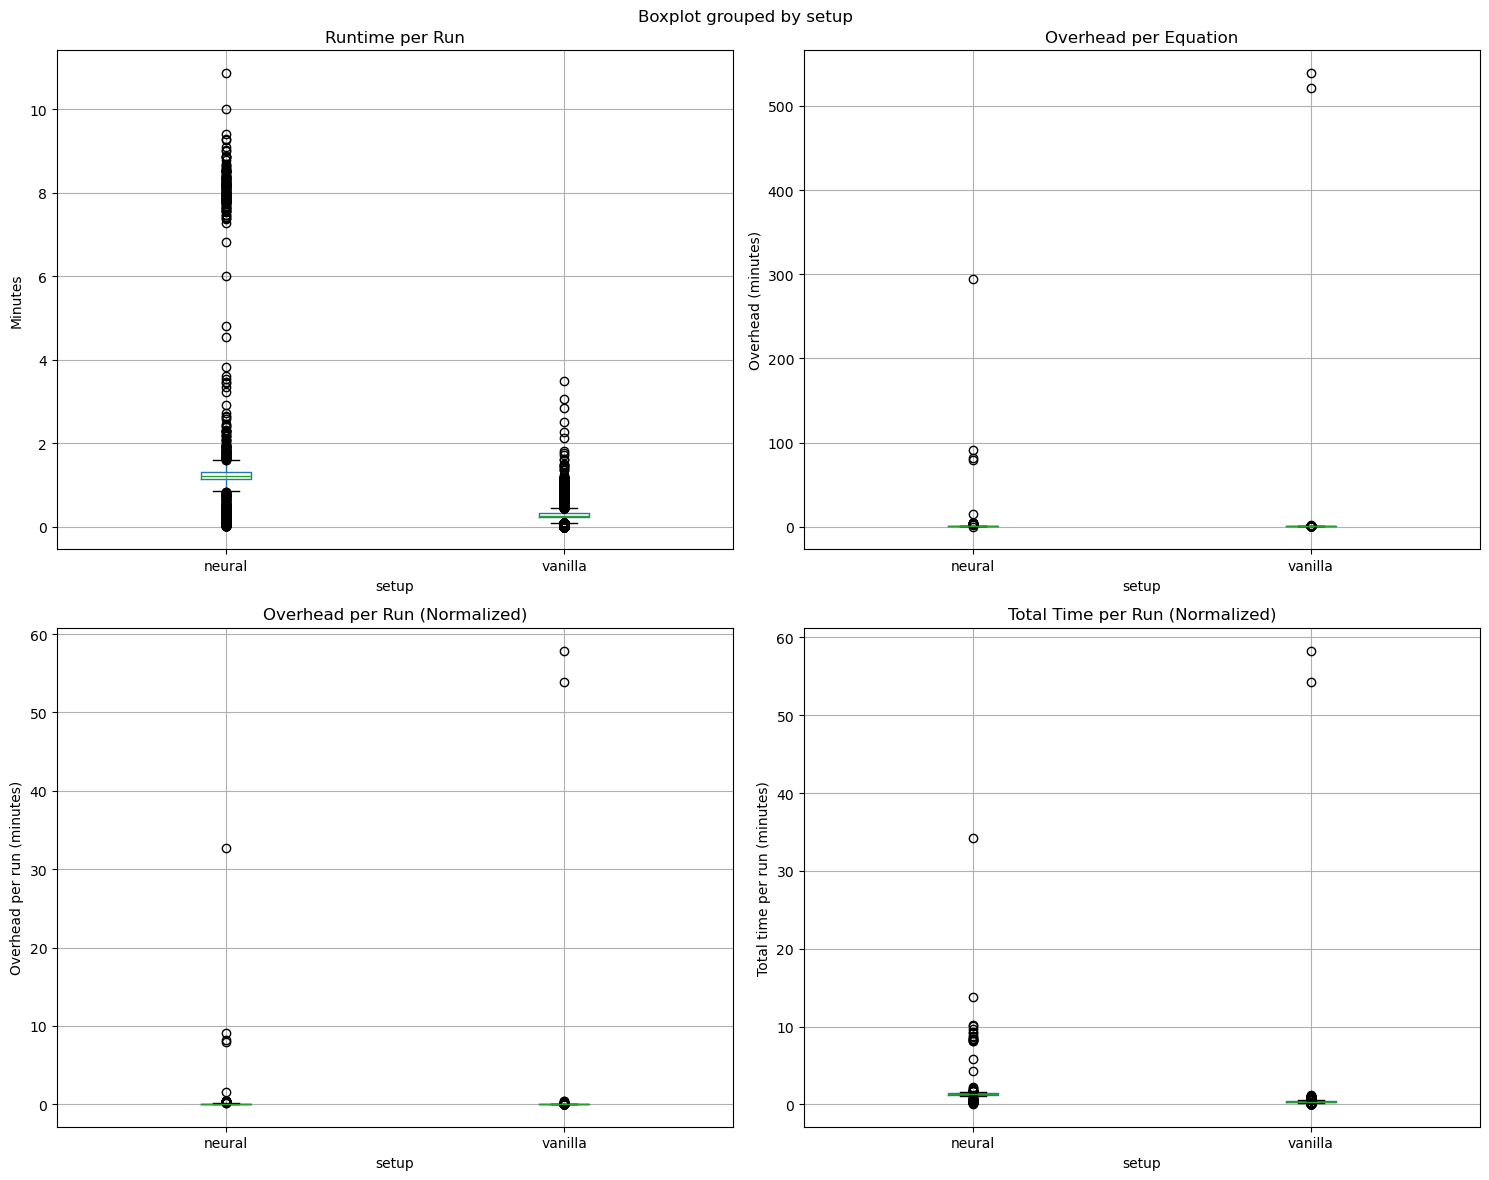

In [15]:
# Runtime per individual run
runtime_data = []
for (dataset, eq, run, setup), group in combined_df.groupby(['dataset', 'eq', 'run', 'setup']):
    if len(group) > 1:
        runtime_minutes = (group['timestamp'].max() - group['timestamp'].min()) / 60
        runtime_data.append({
            'dataset': dataset, 'eq': eq, 'run': run, 'setup': setup,
            'runtime_minutes': runtime_minutes
        })

runtime_df = pd.DataFrame(runtime_data)

# Runtime per equation (all runs for an equation)
equation_runtime_data = []
for (dataset, eq, setup), group in combined_df.groupby(['dataset', 'eq', 'setup']):
    if len(group) > 1:
        total_runtime_minutes = (group['timestamp'].max() - group['timestamp'].min()) / 60
        equation_runtime_data.append({
            'dataset': dataset, 'eq': eq, 'setup': setup,
            'total_runtime_minutes': total_runtime_minutes
        })

equation_runtime_df = pd.DataFrame(equation_runtime_data)

# Calculate overhead per equation
overhead_data = []
for (dataset, eq, setup), eq_group in equation_runtime_df.groupby(['dataset', 'eq', 'setup']):
    run_group = runtime_df[(runtime_df['dataset'] == dataset) & 
                          (runtime_df['eq'] == eq) & 
                          (runtime_df['setup'] == setup)]
    if len(run_group) > 0:
        sum_individual_runs = run_group['runtime_minutes'].sum()
        total_equation_time = eq_group['total_runtime_minutes'].iloc[0]
        overhead_minutes = total_equation_time - sum_individual_runs
        run_count = len(run_group)
        
        overhead_data.append({
            'dataset': dataset, 'eq': eq, 'setup': setup,
            'sum_individual_runs': sum_individual_runs,
            'total_equation_time': total_equation_time,
            'overhead_minutes': overhead_minutes,
            'run_count': run_count,
            'overhead_per_run': overhead_minutes / run_count,
            'total_time_per_run': total_equation_time / run_count
        })

overhead_df = pd.DataFrame(overhead_data)

# Statistics for each setup separately
print(f"\nVANILLA SETUP:")
print("-" * 30)
vanilla_runtime = runtime_df[runtime_df['setup'] == 'vanilla']['runtime_minutes']
vanilla_overhead = overhead_df[overhead_df['setup'] == 'vanilla']

print(f"Per-run runtime (minutes, {len(vanilla_runtime)} runs):")
print(f"  Mean: {vanilla_runtime.mean():.2f}")
print(f"  Median: {vanilla_runtime.median():.2f}")
print(f"  Std: {vanilla_runtime.std():.2f}")

print(f"\nNormalized by run count:")
print(f"  Overhead per run - Mean: {vanilla_overhead['overhead_per_run'].mean():.2f}")
print(f"  Overhead per run - Median: {vanilla_overhead['overhead_per_run'].median():.2f}")
print(f"  Total time per run - Mean: {vanilla_overhead['total_time_per_run'].mean():.2f}")
print(f"  Total time per run - Median: {vanilla_overhead['total_time_per_run'].median():.2f}")

print(f"\nNEURAL SETUP:")
print("-" * 30)
neural_runtime = runtime_df[runtime_df['setup'] == 'neural']['runtime_minutes']
neural_overhead = overhead_df[overhead_df['setup'] == 'neural']

print(f"Per-run runtime (minutes, {len(neural_runtime)} runs):")
print(f"  Mean: {neural_runtime.mean():.2f}")
print(f"  Median: {neural_runtime.median():.2f}")
print(f"  Std: {neural_runtime.std():.2f}")

print(f"\nNormalized by run count:")
print(f"  Overhead per run - Mean: {neural_overhead['overhead_per_run'].mean():.2f}")
print(f"  Overhead per run - Median: {neural_overhead['overhead_per_run'].median():.2f}")
print(f"  Total time per run - Mean: {neural_overhead['total_time_per_run'].mean():.2f}")
print(f"  Total time per run - Median: {neural_overhead['total_time_per_run'].median():.2f}")

# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

runtime_df.boxplot(column='runtime_minutes', by='setup', ax=ax1)
ax1.set_title('Runtime per Run')
ax1.set_ylabel('Minutes')

overhead_df.boxplot(column='overhead_minutes', by='setup', ax=ax2)
ax2.set_title('Overhead per Equation')
ax2.set_ylabel('Overhead (minutes)')

overhead_df.boxplot(column='overhead_per_run', by='setup', ax=ax3)
ax3.set_title('Overhead per Run (Normalized)')
ax3.set_ylabel('Overhead per run (minutes)')

overhead_df.boxplot(column='total_time_per_run', by='setup', ax=ax4)
ax4.set_title('Total Time per Run (Normalized)')
ax4.set_ylabel('Total time per run (minutes)')

plt.tight_layout()
plt.show()

In [45]:
import numpy as np
import pandas as pd
import json
from pathlib import Path

def load_experiment_data(exp_path, equations_to_analyze=None):
    """
    Load tensorboard, neural stats, and run metadata from experiment directory.
    
    Args:
        exp_path: Path to experiment directory
        equations_to_analyze: List of equation indices to filter for (optional)
    
    Returns:
        tuple: (combined_df, neural_stats_df, run_metadata_df) - DataFrames with tensorboard, neural stats, and run metadata
    """
    # Collect all tensorboard scalar data
    all_data = []
    
    # Collect all neural stats data
    all_neural_stats = []
    
    # Collect all run metadata
    all_run_metadata = []
    
    # Filter run directories based on equations if specified
    if equations_to_analyze is not None:
        run_dirs = sorted([d for d in Path(exp_path).glob('*/') if any(f'eq{eq}_' in d.name for eq in equations_to_analyze)])
    else:
        run_dirs = sorted([d for d in Path(exp_path).glob('*/')])
    
    for run_dir in run_dirs:
        run_name = run_dir.name
        tensorboard_file = run_dir / 'tensorboard_scalars.csv'
        neural_stats_file = run_dir / 'neural_stats.json'
        run_metadata_file = run_dir / 'run_metadata.json'
        
        if tensorboard_file.exists():
            try:
                df = pd.read_csv(tensorboard_file)
                df['run_name'] = run_name
                all_data.append(df)
            except Exception as e:
                pass
        
        if neural_stats_file.exists():
            try:
                with open(neural_stats_file, 'r') as f:
                    stats = json.load(f)
                stats['run_name'] = run_name
                all_neural_stats.append(stats)
            except Exception as e:
                pass
        
        if run_metadata_file.exists():
            try:
                with open(run_metadata_file, 'r') as f:
                    metadata = json.load(f)
                metadata['run_name'] = run_name
                all_run_metadata.append(metadata)
            except Exception as e:
                pass
    
    # Combine all data into DataFrames
    combined_df = pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()
    neural_stats_df = pd.DataFrame(all_neural_stats) if all_neural_stats else pd.DataFrame()
    run_metadata_df = pd.DataFrame(all_run_metadata) if all_run_metadata else pd.DataFrame()
    
    return combined_df, neural_stats_df, run_metadata_df

In [50]:
print('=== 40 cores')
combined_df, _, all_run_metadata_1 = load_experiment_data('/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-test-3', [0, 2])
# Calculate total runtime per run (timestamp max - min)
runtime_per_run = combined_df.groupby('run_name')['timestamp'].agg(['min', 'max']).reset_index()
runtime_per_run['total_runtime_seconds'] = runtime_per_run['max'] - runtime_per_run['min']
runtime_per_run['total_runtime_minutes'] = runtime_per_run['total_runtime_seconds'] / 60

# Extract equation number from run names
runtime_per_run['eq'] = runtime_per_run['run_name'].str.extract(r'eq(\d+)_').astype(int)

# Calculate mean runtime per equation
runtime_per_eq = runtime_per_run.groupby('eq')['total_runtime_minutes'].agg(['mean', 'std']).reset_index()
runtime_per_eq.columns = ['eq', 'mean_runtime_minutes', 'std_runtime_minutes']
print(runtime_per_eq)


print('=== 20 cores')
combined_df, _, all_run_metadata_2 = load_experiment_data('/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-4-neural', [0, 2])
# Calculate total runtime per run (timestamp max - min)
runtime_per_run = combined_df.groupby('run_name')['timestamp'].agg(['min', 'max']).reset_index()
runtime_per_run['total_runtime_seconds'] = runtime_per_run['max'] - runtime_per_run['min']
runtime_per_run['total_runtime_minutes'] = runtime_per_run['total_runtime_seconds'] / 60

# Extract equation number from run names
runtime_per_run['eq'] = runtime_per_run['run_name'].str.extract(r'eq(\d+)_').astype(int)

# Calculate mean runtime per equation
runtime_per_eq = runtime_per_run.groupby('eq')['total_runtime_minutes'].agg(['mean', 'std']).reset_index()
runtime_per_eq.columns = ['eq', 'mean_runtime_minutes', 'std_runtime_minutes']
print(runtime_per_eq)

=== 40 cores
   eq  mean_runtime_minutes  std_runtime_minutes
0   0              0.000000             0.000000
1   2              2.078511             0.091012
=== 20 cores
   eq  mean_runtime_minutes  std_runtime_minutes
0   0              0.000000               0.0000
1   2              1.219447               0.0931


In [33]:
neural_stats_subset = neural_stats_df[['run_name', 'total_attempts', 'total_samples']].copy()
neural_stats_subset['samples_per_attempt'] = (neural_stats_subset['total_samples'] / neural_stats_subset['total_attempts']).round(0).astype(int)
neural_stats_subset.sort_values('run_name')

,run_name,total_attempts,total_samples,samples_per_attempt
6,pysr-univariate_eq0_run0,956,14393,15
1,pysr-univariate_eq0_run1,16257,191637,12
3,pysr-univariate_eq0_run2,19849,275922,14
5,pysr-univariate_eq0_run3,22247,413090,19
10,pysr-univariate_eq0_run4,19102,292253,15
11,pysr-univariate_eq1_run0,465368,9192363,20
0,pysr-univariate_eq1_run1,455955,9592325,21
7,pysr-univariate_eq1_run2,457824,8598483,19
2,pysr-univariate_eq1_run3,434985,8412754,19
9,pysr-univariate_eq1_run4,462538,9188417,20


In [35]:
import numpy as np
import pandas as pd
import json
from pathlib import Path

exp_path = '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-4-neural'

# Collect all tensorboard scalar data
all_data = []

# Collect all neural stats data
all_neural_stats = []

# Get only eq0 and eq1 runs
run_dirs = sorted([d for d in Path(exp_path).glob('*/') if 'eq0_' in d.name or 'eq2_' in d.name])

for run_dir in run_dirs:
    run_name = run_dir.name
    tensorboard_file = run_dir / 'tensorboard_scalars.csv'
    neural_stats_file = run_dir / 'neural_stats.json'
    
    if tensorboard_file.exists():
        try:
            df = pd.read_csv(tensorboard_file)
            df['run_name'] = run_name
            all_data.append(df)
        except Exception as e:
            pass
    
    if neural_stats_file.exists():
        try:
            with open(neural_stats_file, 'r') as f:
                stats = json.load(f)
            stats['run_name'] = run_name
            all_neural_stats.append(stats)
        except Exception as e:
            pass

# Combine all data into one large DataFrame
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)

# Combine all neural stats into one DataFrame
if all_neural_stats:
    neural_stats_df = pd.DataFrame(all_neural_stats)

neural_stats_subset = neural_stats_df[['run_name', 'total_attempts', 'total_samples']].copy()
neural_stats_subset['samples_per_attempt'] = (neural_stats_subset['total_samples'] / neural_stats_subset['total_attempts']).round(0).astype(int)
neural_stats_subset.sort_values('run_name')

,run_name,total_attempts,total_samples,samples_per_attempt
0,pysr-univariate_eq0_run0,245,6065,25
1,pysr-univariate_eq0_run1,99,392,4
2,pysr-univariate_eq0_run2,4448,63458,14
3,pysr-univariate_eq0_run3,5125,80792,16
4,pysr-univariate_eq0_run4,4391,50304,11
5,pysr-univariate_eq0_run5,4956,67778,14
6,pysr-univariate_eq0_run6,5410,85375,16
7,pysr-univariate_eq0_run7,5210,81797,16
8,pysr-univariate_eq0_run8,6042,92276,15
9,pysr-univariate_eq0_run9,5291,85645,16


In [36]:
import numpy as np
import pandas as pd
import json
from pathlib import Path

exp_path = '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-test-3'

# Collect all tensorboard scalar data
all_data = []

# Collect all neural stats data
all_neural_stats = []

# Get only eq0 and eq1 runs
run_dirs = sorted([d for d in Path(exp_path).glob('*/') if 'eq0_' in d.name or 'eq2_' in d.name])

for run_dir in run_dirs:
    run_name = run_dir.name
    tensorboard_file = run_dir / 'tensorboard_scalars.csv'
    neural_stats_file = run_dir / 'neural_stats.json'
    
    if tensorboard_file.exists():
        try:
            df = pd.read_csv(tensorboard_file)
            df['run_name'] = run_name
            all_data.append(df)
        except Exception as e:
            pass
    
    if neural_stats_file.exists():
        try:
            with open(neural_stats_file, 'r') as f:
                stats = json.load(f)
            stats['run_name'] = run_name
            all_neural_stats.append(stats)
        except Exception as e:
            pass

# Combine all data into one large DataFrame
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)

# Combine all neural stats into one DataFrame
if all_neural_stats:
    neural_stats_df = pd.DataFrame(all_neural_stats)

neural_stats_subset = neural_stats_df[['run_name', 'total_attempts', 'total_samples']].copy()
neural_stats_subset['samples_per_attempt'] = (neural_stats_subset['total_samples'] / neural_stats_subset['total_attempts']).round(0).astype(int)
neural_stats_subset.sort_values('run_name')

,run_name,total_attempts,total_samples,samples_per_attempt
0,pysr-univariate_eq0_run0,119,998,8
1,pysr-univariate_eq0_run1,4869,64709,13
2,pysr-univariate_eq0_run2,5346,76583,14
3,pysr-univariate_eq0_run3,5751,83146,14
4,pysr-univariate_eq0_run4,4589,77475,17
5,pysr-univariate_eq0_run5,6102,93860,15
6,pysr-univariate_eq0_run6,5588,80465,14
7,pysr-univariate_eq0_run7,5075,66669,13
8,pysr-univariate_eq0_run8,5328,76422,14
9,pysr-univariate_eq0_run9,4722,88030,19
